**GENERAL THOUGHTS:**
- ...


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order



**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [ ]:
import os
import pickle
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import yaml
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

# import xgboost as xgb
# import lightgbm as lgbm

with open("../env_vars.yml", "r") as file:
    config = yaml.safe_load(file)

# custom imports
sys.path.append(config["project_directory"])
from src import utils

In [4]:
SEED = 42

clf_name = "best_clf"

# Get current date and time
now = datetime.now()
# Format date and time
formatted_date_time = now.strftime("%Y-%m-%d_%H:%M:%S")
print(formatted_date_time)

2024-11-22_01:48:24


# Load data

In [5]:
df = pd.read_csv(f"{config['data_directory']}/output/df_ml.csv", sep="\t")

# Prep data for machine learning

In [ ]:
df["material_number"] = df["material_number"].astype("object")

df_sub = df[
    [
        "material_number",
        "brand",
        "product_area",
        "core_segment",
        "component",
        "manufactoring_location",
        "characteristic_value",
        "material_weight",
        "packaging_code",
        "packaging_category",
    ]
]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


In [7]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [ ]:
distribution_classes = y.value_counts()
print("Class distribution before oversampling")
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversampling = {
    "Metal Cassette": 100,
    "Carton tube with or w/o": 100,
    "Wooden box": 100,
    "Fabric packaging": 100,
    "Book packaging": 100,
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversampling, random_state=SEED)
# fit and apply the transform
X_oversample, y_oversample = oversampler.fit_resample(X, y)

distribution_classes = y_oversample.value_counts()
print("\n")
print("Class distribution after oversampling")
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap Folding Card': 2188, 'Plastic Pouch': 1904, 'Plastic bag with header': 1850, 'Plastic Cassette': 1708, 'Shrink film and insert o': 1499, 'Plastic Box': 1491, 'Unpacked': 1415, 'Skincard': 1143, 'Trap Card': 804, 'Cardb. Sleeve w - w/o Shr.': 676, 'Carton cover (Lid box)': 652, 'Case': 485, 'Tray Packer': 431, 'Cardboard hanger w/o bag': 400, 'Envelope': 295, 'Countertop display': 150, 'Metal Cassette': 50, 'Carton tube with or w/o': 44, 'Wooden box': 16, 'Fabric packaging': 15, 'Book packaging': 10}


Class distribution after oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap 

In [ ]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversample,
    y_oversample,
    test_size=0.2,
    stratify=y_oversample,
    # random_state=SEED
)

# Best model pipeline

In [ ]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include="number").columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("log_transform", PowerTransformer()),
        # ('scale', MinMaxScaler())
    ]
)
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude="number").columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
        # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
    ]
)
# apply both pipeline on separate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("number", numeric_feature_pipeline, numerical_features),
        ("category", categorical_feature_pipeline, categorical_features),
    ]
)

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
# y_train_transformed = label_encoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_transformed), y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_params = {"n_estimators": 500, "max_depth": 20, "criterion": "entropy"}

best_model = RandomForestClassifier(
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

# Training
best_model.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(class_weight={0: 0.3286731902097557,
                                     1: 0.36320204826496705,
                                     2: 28.738362068965518,
                                     3: 4.249665370641851,
                                     4: 7.1845905172413795,
                                     5: 4.404346677236094,
                                     6: 28.738362068965518, 7: 5.92543547813722,
                                     8: 0.7421139333496583,
                                     9: 19.15890804597701,
                                     10: 9.741817650496786,
                                     11: 28.738362068965518,
                                     12: 0.349668283728858,
                                     13: 0.2122086916667197,
                                     14: 28.738362068965518,
                                     15: 0.8264086863829049,
                                     16: 1.9271324103245946,
                                     17: 1.6830665926187711,
                                     18: 1.5095659655398828,
                                     19: 1.5534249767008388,
                                     20: 1.9174887118575825,
                                     21: 2.5153927412661283,
                                     22: 0.34640183298436666,
                                     23: 3.5755349385960207,
                                     24: 1.3137536945812809,
                                     25: 6.663968015992004,
                                     26: 0.24588972893232527,
                                     27: 2.0309796515169976,
                                     28: 28.738362068965518},
                       criterion='entropy', max_depth=20, n_estimators=500)

In [11]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = best_model.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", best_model.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", best_model.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  0.9539093786090321
Test score (f1-score):  0.7877497150398944
                            precision    recall  f1-score   support

   Blister and Insert Card       0.77      0.80      0.78      1749
  Blister and sealed blist       0.77      0.76      0.76      1582
            Book packaging       0.91      1.00      0.95        20
Cardb. Sleeve w - w/o Shr.       0.46      0.44      0.45       135
  Cardboard hanger w/o bag       0.35      0.56      0.43        80
    Carton cover (Lid box)       0.47      0.62      0.53       130
   Carton tube with or w/o       0.69      0.90      0.78        20
                      Case       0.27      0.52      0.35        97
         Corrugated carton       0.79      0.72      0.75       774
        Countertop display       0.76      0.43      0.55        30
                  Envelope       0.86      0.86      0.86        59
          Fabric packaging       1.00      1.00      1.00        20
            Folding carton  

In [ ]:
# Create df with y_test, preds_y_test & proba_preds_y_test

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba["predicted_class_proba"] = df_proba.max(axis=1)
proba_preds_y_test = df_proba["predicted_class_proba"].values

y_test_dict = {
    "y_test": y_test.to_numpy(),
    "preds_y_test": preds_y_test_inverse,
    "proba_preds_y_test": proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,0.999929
1,TightPack,Plastic Cassette,0.543884
2,TightPack,TightPack,0.984380
3,Corrugated carton,Corrugated carton,0.907055
4,Hanger/ Clip,Hanger/ Clip,0.999283
5,Hanger/ Clip,Hanger/ Clip,0.993918
6,Plastic Pouch,Plastic Pouch,0.969720
7,Envelope,Envelope,0.923539
8,Folding carton,Folding carton,0.966000
9,Carton cover (Lid box),Carton cover (Lid box),0.938866


# Business Decision Optimization

Learn to optimize decision rules, translating machine learning predictions into actionable insights. Discover how to achieve practical value and business impact by measuring performance using business metrics.  
- Translate Machine Learning Predictions Into Actionable Business Insights  
Identify decision and prediction problems and optimize them using advanced machine learning models.  
- Master Business Impact Measurement for ML Models  
Instead of relying solely on accuracy metrics, it is shown how to measure the performance of your ML models in business value terms. Discover the power of using profit curves for optimizing multi-class decisions, and uncover how to address their basic limitations.

Inspired by: https://github.com/wandb/edu/tree/main/decision-opt-course

<Figure size 1000x500 with 0 Axes>

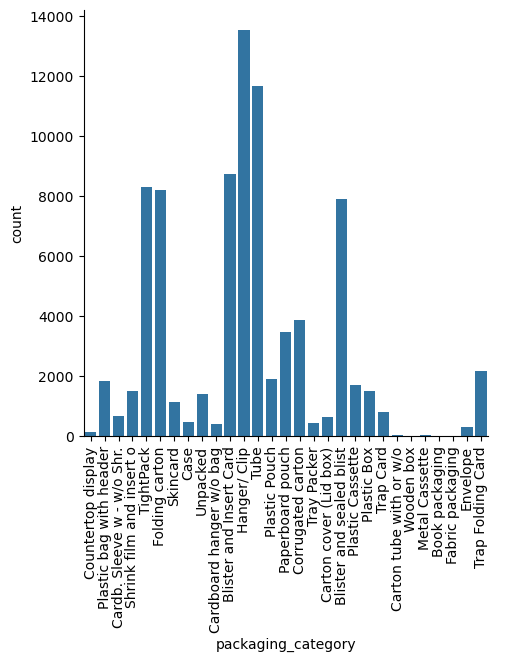

In [ ]:
# class distribution (after oversampling)
plt.figure(figsize=(10, 5))
cat_chart = sns.catplot(
    data=df_sub,
    x="packaging_category",
    kind="count",
)
cat_chart.set_xticklabels(rotation=90)

### Standard Confusion Matrix

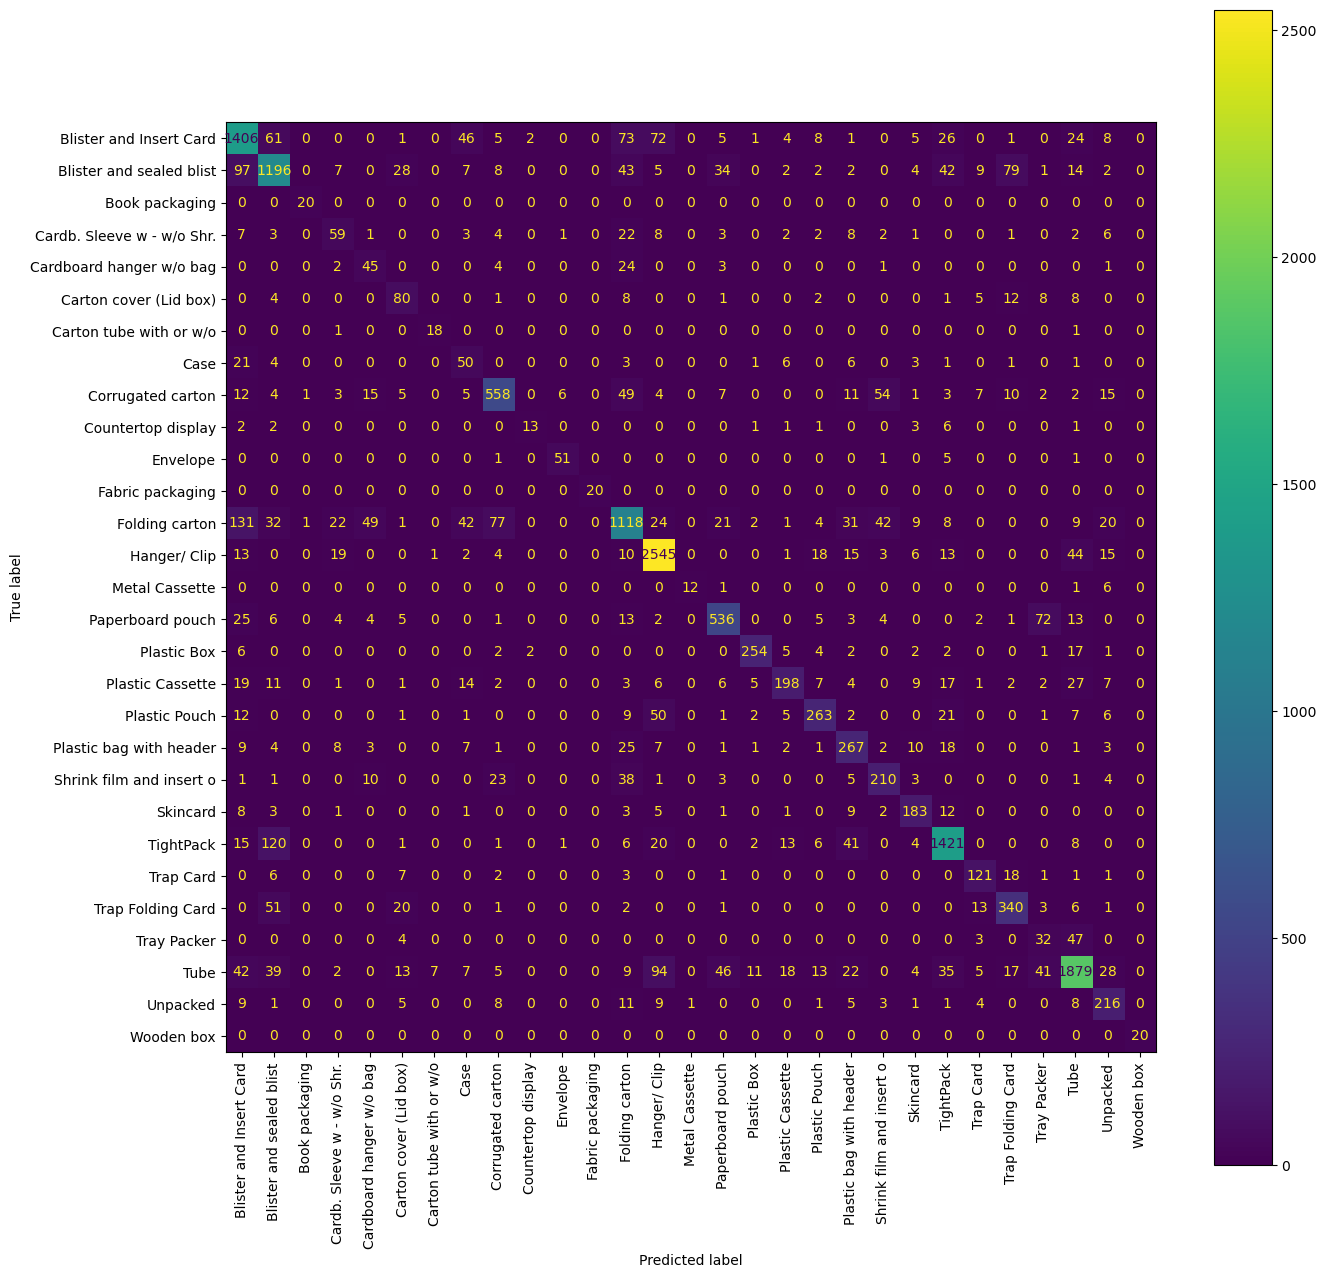

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    values_format=".0f",
    ax=ax,
    xticks_rotation="vertical",
)

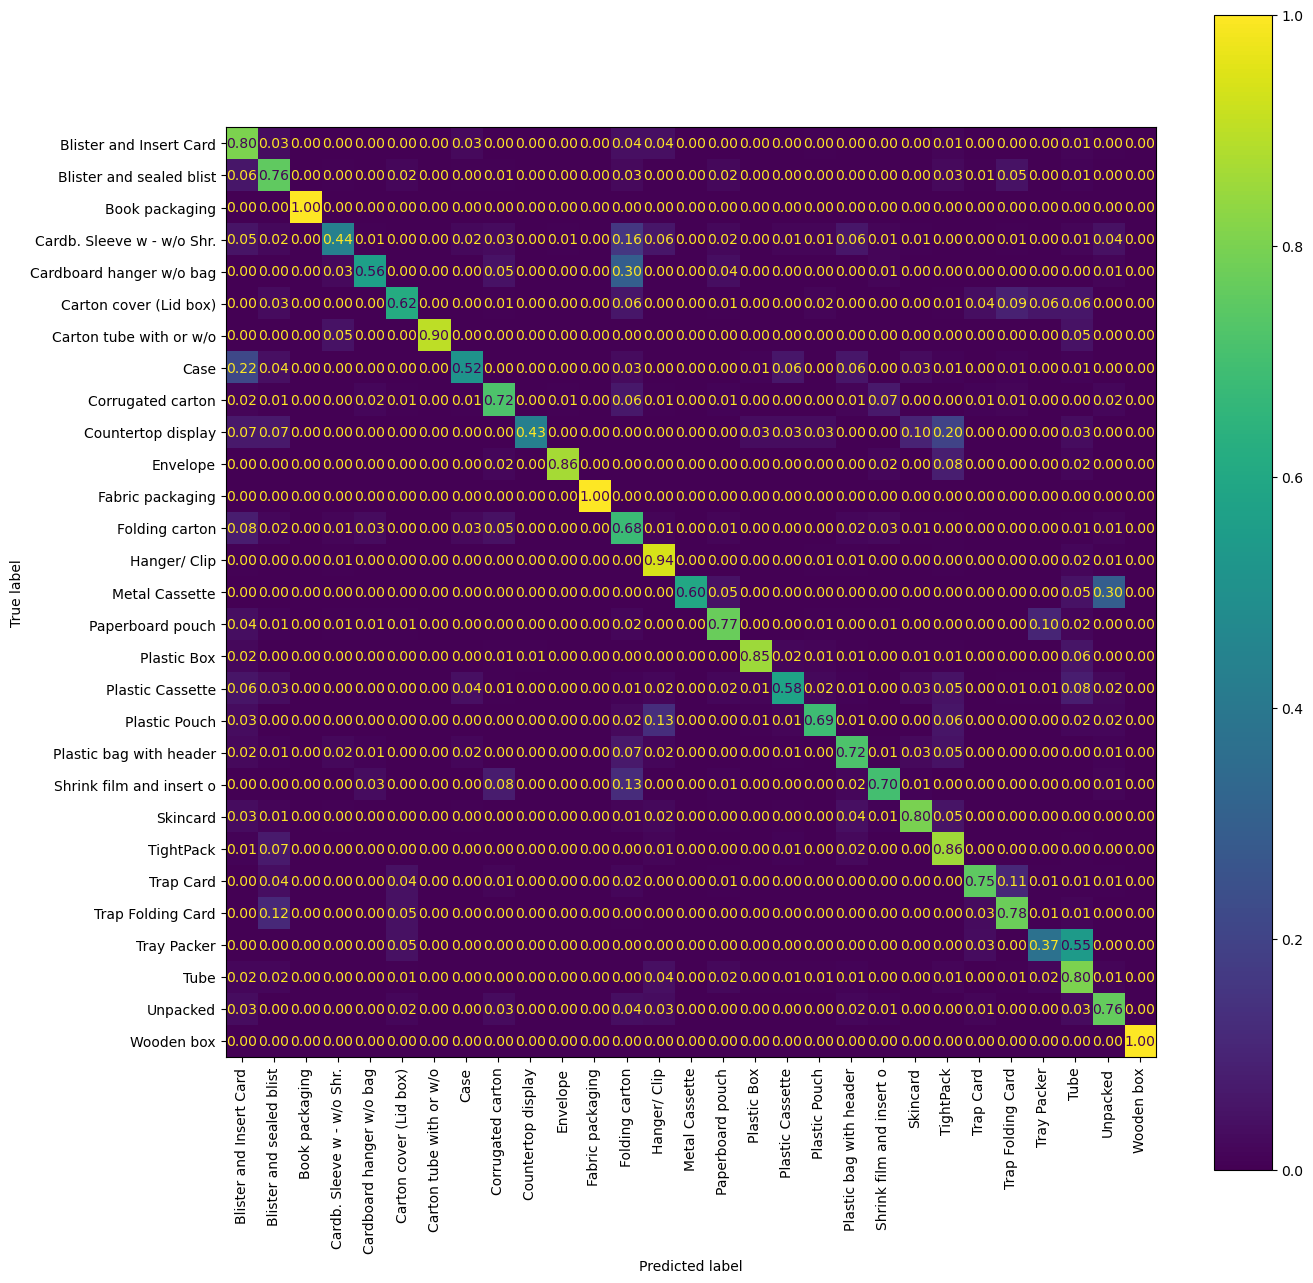

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize="true",
    values_format=".2f",
    ax=ax,
    xticks_rotation="vertical",
)

## Threshold analysis (since best model provides probabilistic forecasts)

A threshold analysis gives insights if we want to exclude specific packaging categories for which the model performance does not meet a threshold. The threshold used is based on the probability given by the model. The probability is calculated based on the percentage of correct predictions of the single trees within the random forest model.  
From a business perspective we might want to exclude categories to improve performance and ensure low classification errors with the cost of not providing predictions for the right packaging for some products. Wrong predictions have no or even a negative value and therefore might rather be approached manually.  
The threshold analysis is used to determine an "optimal" threshold based on the ration between performance and product coverage. This is a great way to ensure specific performance requirements are met. But it does not provide a cost (business) trade-off analysis, what we will do in the step after.

In [16]:
df_y_test.head()

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,0.999929
1,TightPack,Plastic Cassette,0.543884
2,TightPack,TightPack,0.984380
3,Corrugated carton,Corrugated carton,0.907055
4,Hanger/ Clip,Hanger/ Clip,0.999283


In [ ]:
# threshold None
# best_mode_clf_report = classification_report(df_y_test.y_test, df_y_test.preds_y_test, output_dict=True)
print(classification_report(df_y_test.y_test, df_y_test.preds_y_test))

                            precision    recall  f1-score   support

   Blister and Insert Card       0.77      0.80      0.78      1749
  Blister and sealed blist       0.77      0.76      0.76      1582
            Book packaging       0.91      1.00      0.95        20
Cardb. Sleeve w - w/o Shr.       0.46      0.44      0.45       135
  Cardboard hanger w/o bag       0.35      0.56      0.43        80
    Carton cover (Lid box)       0.47      0.62      0.53       130
   Carton tube with or w/o       0.69      0.90      0.78        20
                      Case       0.27      0.52      0.35        97
         Corrugated carton       0.79      0.72      0.75       774
        Countertop display       0.76      0.43      0.55        30
                  Envelope       0.86      0.86      0.86        59
          Fabric packaging       1.00      1.00      1.00        20
            Folding carton       0.76      0.68      0.72      1644
              Hanger/ Clip       0.89      0.94

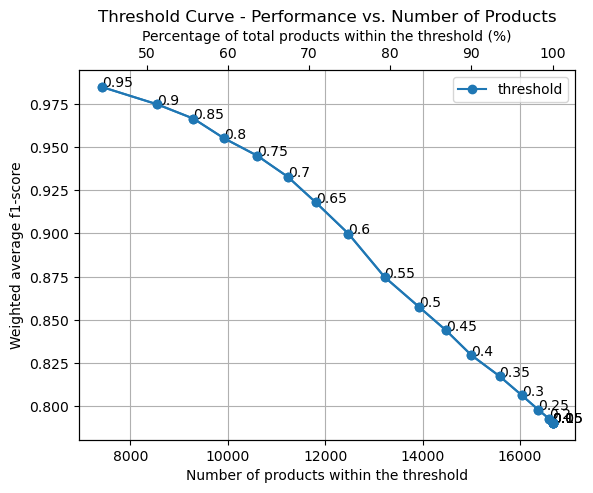

In [ ]:
def threshold_analysis_f1(thresholds: list, df_y_test: pd.DataFrame):
    # TODO: add description
    # TODO: refactor function to make it usable for any metric within classification_report

    clf_reports = []

    for threshold in thresholds:
        df_y_test_threshold = df_y_test.loc[df_y_test.proba_preds_y_test >= threshold]

        clf_report = classification_report(
            df_y_test_threshold.y_test, df_y_test_threshold.preds_y_test, output_dict=True
        )
        clf_reports.append(clf_report)

    f1_scores = []
    supports = []

    for _, clf_report in enumerate(clf_reports):
        f1_scores.append(clf_report["weighted avg"]["f1-score"])
        supports.append(clf_report["weighted avg"]["support"])

    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()  # Create a twin x-axis that shares the y-axis with ax1

    ax1.plot(supports, f1_scores, "o-", label="threshold")
    for i, txt in enumerate(thresholds):
        ax1.annotate(txt, (supports[i], f1_scores[i]))

    # New x-axis for percentage of products
    ax2.plot(
        [x / len(df_y_test) * 100 for x in supports], f1_scores, "o-"
    )  # Note the transformation of supports to %

    ax1.legend()
    ax1.grid()
    ax1.set_title("Threshold Curve - Performance vs. Number of Products")
    ax1.set_xlabel("Number of products within the threshold")
    ax2.set_xlabel("Percentage of total products within the threshold (%)")
    ax1.set_ylabel("Weighted average f1-score")

    plt.show()

    return clf_reports


# thresholds = [0, 0.80, 0.85, 0.90, 0.95]
thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

clf_reports = threshold_analysis_f1(thresholds=thresholds, df_y_test=df_y_test)


In [ ]:
# NOTE: Matplotlib code variation: plt. instead of fig./ax.

# def threshold_analysis(thresholds: list, df_y_test: pd.DataFrame):

#     # calculate individual clf reports for the data (subset of packaging categories) that fulfill the threshold condition
#     clf_reports = []

#     for threshold in thresholds:
#         df_y_test_threshold = df_y_test.loc[
#             df_y_test.proba_preds_y_test >= threshold
#         ]

#         clf_report = classification_report(df_y_test_threshold.y_test, df_y_test_threshold.preds_y_test, output_dict=True)
#         clf_reports.append(clf_report)

#     # plot threshold curve
#     f1_scores = []
#     supports = []

#     for j, clf_report in enumerate(clf_reports):
#         f1_scores.append(clf_report['weighted avg']['f1-score'])
#         supports.append(clf_report['weighted avg']['support'])

#     plt.plot(supports, f1_scores, 'o-', label='threshold')
#     for i, txt in enumerate(thresholds):
#         plt.annotate(txt, (supports[i], f1_scores[i])) # Adding the annotation
#     plt.legend()
#     plt.grid()
#     plt.title('Threshold Curve - Performance vs. Number of Products')
#     plt.xlabel('Number of products within the threshold')
#     plt.ylabel('weighted average f1-score')
#     plt.show()

#     return clf_reports


# # thresholds = [0, 0.80, 0.85, 0.90, 0.95]
# thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

# clf_reports = threshold_analysis(thresholds=thresholds, df_y_test=df_y_test)

## Cost trade-off anaylsis (business perspective)

In the previous step we introduced a threshold analysis to determine an "optimal" threshold based on the ration between performance and product coverage.  
In the next step we will add a payoff-matrix that reflects business costs of "true" and "false" predictions, as well as individual class weights. By doing so we are able to assesses the business value/cost behind the performance on an individual class (package category) importance (value).

### Define class categories into 3 importance groups

In [ ]:
first_level_categories = [
    "Cardb. Sleeve w - w/o Shr.",
    "Folding carton",
    "Unpacked",
    "Cardboard hanger w/o bag",
    "Paperboard pouch",
    "Corrugated carton",
    "Carton cover (Lid box)",
    "Trap Card",
    "Carton tube with or w/o",
    "Wooden box",
    "Book packaging",
    "Fabric packaging",
    "Envelope",
    "Trap Folding Card",
    "Skincard",
]

second_level_categories = [
    "Blister and Insert Card",
    "Hanger/ Clip",
    "Plastic Cassette",
    "Tube",
    "Blister and sealed blist",
    "Case",
    "TightPack",
    "Shrink film and insert o",
    "Plastic Pouch",
    "Plastic Box",
    "Plastic bag with header",
]

# create subset based on importance of categorie
print("shape df_sub: ", df_sub.shape)

df_first_level = df_sub.loc[df_sub.packaging_category.isin(first_level_categories)]
print("shape df_first_level: ", df_first_level.shape)

df_second_level = df_sub.loc[df_sub.packaging_category.isin(second_level_categories)]
print("shape df_second_level: ", df_second_level.shape)

df_third_level = df_sub.loc[
    (~df_sub.packaging_category.isin(first_level_categories))
    & (~df_sub.packaging_category.isin(second_level_categories))
]
print("shape df_third_level: ", df_third_level.shape)

print(
    "Shapes are consistent: ",
    df_sub.shape[0]
    == df_first_level.shape[0] + df_second_level.shape[0] + df_third_level.shape[0],
)

third_level_categories = list(df_third_level.packaging_category.unique())

print(len(first_level_categories))
print(len(second_level_categories))
print(len(third_level_categories))

shape df_sub:  (82977, 10)
shape df_first_level:  (23227, 10)
shape df_second_level:  (59119, 10)
shape df_third_level:  (631, 10)
Shapes are consistant:  True


### Define payoff-matrix with consideration of each importance group

The payoff-matrix reflects the cost behind our packaging classification task. In this case the costs reflects a combination of time-effort and financial costs. Those cost might be different for TP, FP, TN and FN and therefore need to be defined for each class independently, which results on a payoff-matrix for each class.    
To simplify the payoff-matrix for multi-class classification we assume the following:
- We only distinguish between TP, FN, FP and TN but do not consider single classes
- Cost matrix is defined as as [[1, 30], [50, 1]] and relates to the format [[TP, FN], [FP, TN]]
- Class importance is reflected in a cost-factor for each importance group:
  - first_level_categories cost-factor: 1
  - second_level_categories cost-factor: 2
  - third_level_categories cost-factor: 3

####1321279
####1321279
####1321279
####1321181
####1316407
####1301464
####1278148
####1246539
####1205506
####1169624
####1129679
####1079125
####1025965
####977067
####933870
####885502
####830744
####781292
####721041
####626656


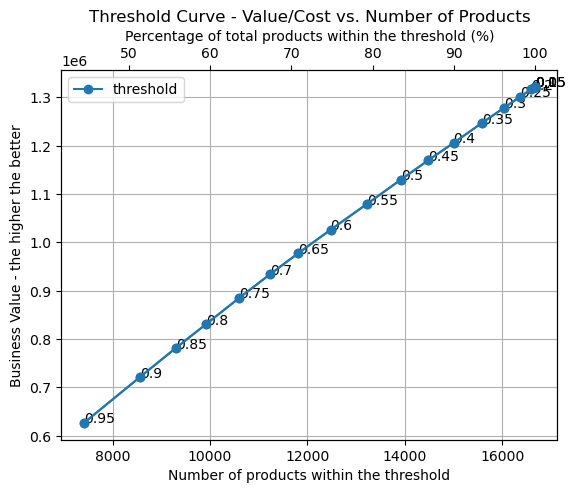

In [ ]:
# TODO: add relative costs -> cost per product and not absolute costs for all products (or both) -> might not make sense since we plot multiple curves!
# TODO: plot another graph of costs that represents the costs for manually labeling of packaging categories
# TODO: besides those aspect, plot multiple graphs for different thresholds (from above)


def threshold_analysis_cost(
    thresholds: list, df_y_test: pd.DataFrame, unique_classes: list = None
) -> None:
    """
    costs: positive costs mean positive business value, negative costs mean negative business value
    values of unique_classes and class_weights must match!
    """

    costs = []
    supports = []

    for threshold in thresholds:
        df_y_test_threshold = df_y_test.loc[df_y_test.proba_preds_y_test >= threshold]

        # define class weights
        # TODO: add class_weights_dict to function arguments
        dict_first_lvl_weights = {key: 4 for key in first_level_categories}
        dict_second_lvl_weights = {key: 2 for key in second_level_categories}
        dict_third_lvl_weights = {key: 1 for key in third_level_categories}
        class_weights_dict = (
            dict_first_lvl_weights | dict_second_lvl_weights | dict_third_lvl_weights
        )

        # prep inputs to calc business costs
        # TODO: add confusion matrix to function arguments
        cm_sub = confusion_matrix(
            df_y_test_threshold["y_test"],
            df_y_test_threshold["preds_y_test"],
            labels=np.sort(unique_classes),
        )
        # TODO: add cost matrix to function arguments
        cost_matrix = np.array([[1, -3], [-5, 1]])  # [[TP, FN], [FP, TN]]
        class_weights = dict(sorted(class_weights_dict.items()))

        cost = utils.calculate_weighted_cost(
            cm_sub, cost_matrix, method="weighted", class_weights=class_weights
        )  # class_weights must be in the same order as the labels used in the confusion matrix.
        costs.append(cost)

        support = df_y_test_threshold.shape[0]
        supports.append(support)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()  # Create a twin x-axis that shares the y-axis with ax1

    ax1.plot(supports, costs, "o-", label="threshold")
    for i, txt in enumerate(thresholds):
        ax1.annotate(txt, (supports[i], costs[i]))

    # New x-axis for percentage of products
    ax2.plot(
        [x / len(df_y_test) * 100 for x in supports], costs, "o-"
    )  # Note the transformation of supports to %

    ax1.legend()
    ax1.grid()
    ax1.set_title("Threshold Curve - Value/Cost vs. Number of Products")
    ax1.set_xlabel("Number of products within the threshold")
    ax2.set_xlabel("Percentage of total products within the threshold (%)")
    ax1.set_ylabel("Business Value - the higher the better")

    plt.show()

    return


# thresholds = [0, 0.80, 0.85, 0.90, 0.95]
thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

threshold_analysis_cost(
    thresholds=thresholds,
    df_y_test=df_y_test,
    unique_classes=df_sub["packaging_category"].unique(),
)


- Importance of packaging classes
  - first level: suitable for the product
  - second level: standard packaging
  - third level: special packaging
- Model Confidence: is based on single cases (single data points) and does not represent the confidence per classification level.
  - Further more the model confidence does not represent (true) probability.
  - Further more the model confidence is not a good indicator for the model performance.
- Macro vs Micro Averaging:
- Threshold Curve - Performance vs. Number of Products: as we can see we can achieve a good performance with a small number of products, or in other words, we can cover a larger number of products with the cost of a decrease in performance.
  - We can also see that at a certain point with a decrease in performance we reach a plateau for adding more products (~0.2 model prediction confidence).
- Threshold Curve - Value/Costs vs. Number of Products: as we can see the relationship is nearly linear. This connects to the related confusion matrix. For nearly all classes have a relatively high accuracy (acc = (TP + TN) / (TP + TN + FP + FN)). Related to "Threshold Curve - Value/Costs vs. Number of Products" this means that only a small amount of products cause negative costs/value and therefore do not have a significant impact on the overall costs/value.
  - The scale of the costs/value has no direct implication, since we do not compare it to a baseline (like fully manual classification).
  - Conclusion: since the curve does not reach a plateau or decries we can increase business value even though we trade off model performance.
- Conclusion based on both Threshold Curves:
  - Still might want to define a threshold for the model confidence based on "Threshold Curve - Performance vs. Number of Products" and go with a manual classification for the remaining products.

In [ ]:
# NOTE: come up with in idea how to build a base line curve based on a ratio. ratio: ration * TP (true manual classification). ration is the factor that describes the difference between automatic and manual classification.